# Bootstrapping mini-project

## Introduction

In this mini-project, I perform some bootstrapping analyses of a medical charges dataset. I first import the correct modules and datasets and then move on to bootstapping

In [1]:
import pandas as pd
import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt

In [2]:
med_charges = pd.read_csv('data/insurance2.csv')

In [3]:
med_charges.head()

,age,sex,bmi,children,smoker,region,charges,insuranceclaim
0,19,0,27.900,0,1,3,16884.92400,1
1,18,1,33.770,1,0,2,1725.55230,1
2,28,1,33.000,3,0,2,4449.46200,0
3,33,1,22.705,0,0,1,21984.47061,0
4,32,1,28.880,0,0,1,3866.85520,1


__Q:__ Use bootstrap sampling to estimate the same 95% confidence interval lower limit as before.

__A:__ The lower 95% CI is 12724

In [4]:
np.random.seed(47)
N_rep = 10000

# First, define a bootstrapping function.
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = func(np.random.choice(data, size=len(data)))

    return bs_replicates

bs_sample = draw_bs_reps(med_charges['charges'], np.mean, 10000)

CI_lower = np.percentile(bs_sample, 5)

print('The lower 95% CI is ' '{:.0f}'.format(CI_lower))



The lower 95% CI is 12724


__Q:__ Calculate the 95% confidence interval for the difference between the standard deviations of insurance and non-insurance claim charges (insured - non-insured). Calculate the differences over 10000 replicates. Plot the histogram of values and mark the locations of the percentiles. State the null and alternative hypothesis and comment on whether you would retain or reject the null hypothesis in this case and why.

__A:__ The null hypothesis is that the standard deviations do not differ. The alternative hypothesis is that the standard deviations differ (this is non-directional / two-tailed).
As shown below, the 95% CI for the difference in standard deviations is [-$8506, -$6691] which does not contain zero. Nor do any of our bootstrap replicates have a value of 0 (max is -$5725). Thus, we would reject the null hypothesis.

We note that the negative sign indicates that the uninsured have much larger standard deviations in charges than the insured.


In [5]:
# We can use the bootstrapping function defined above but with a different statistic.

# Bootstrap the standard deviation for both the insured and uninsured.
boot_sd_insured = draw_bs_reps(med_charges['charges'][med_charges['insuranceclaim']==0], 
                               np.std, 10000)
boot_sd_uninsured = draw_bs_reps(med_charges['charges'][med_charges['insuranceclaim']==1], 
                               np.std, 10000)

# Then, construct the difference between the two resampled standard deviations.
diff_boot_sd = boot_sd_insured - boot_sd_uninsured



In [6]:
# The CI is shown below
lower_limit, upper_limit = np.percentile(diff_boot_sd, [2.5, 97.5])
max_diff = max(diff_boot_sd)

print('The 95% CI was ' + '{:.0f}'.format(lower_limit) + ', ' + '{:.0f}'.format(upper_limit))
print('The maximum value of the difference was ' + '{:.0f}'.format(max_diff))


The 95% CI was -8487, -6674
The maximum value of the difference was -5922


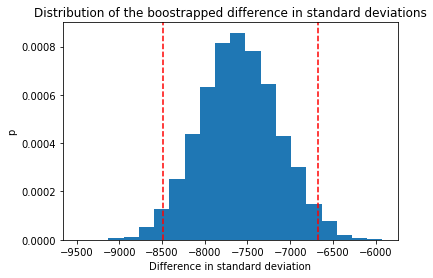

In [7]:
#Now we can plot those
_ = plt.hist(diff_boot_sd, bins = 20, density=True)
_ = plt.xlabel('Difference in standard deviation')
_ = plt.ylabel('p')
_ = plt.title('Distribution of the boostrapped difference in standard deviations')
_ = plt.axvline(lower_limit, color='r', linestyle='--')
_ = plt.axvline(upper_limit, color='r', linestyle='--')
plt.show()


## Confidence interval and p-value

__Q:__ Perform a bootstrapped hypothesis test at the 5% significance level ($\alpha = 0.05$) to calculate the p-value of the observed difference between insurance and non-insurance charges, state your null and alternative hypotheses and whether you retain or reject the null hypothesis for the given significance level.

__A:__ 
Ho: The mean charge for insured patients equals for mean for non-insured patients (equivalent to saying the group labeling makes no difference / is random).
Ha: The mean charge for insured patients differs from the mean for non-insured patients (or the group labeling is more informative than expected by chance alone)

This can be run as a permutation test. We assume that the labelling of insured and non-insured make no difference.

We reject the null hypothesis, as p-value is

In [20]:
# First, let's extract the two series to make the code cleaner
insured_charges = med_charges['charges'][med_charges['insuranceclaim']==0]
uninsured_charges = med_charges['charges'][med_charges['insuranceclaim']==1]
#observed mean difference
obs_mean_diff = np.mean(insured_charges) - np.mean(uninsured_charges)
print(obs_mean_diff)

-7602.506384231368


In [58]:
def draw_perm_reps(data_1, data_2, size=1):
    """Generate multiple permutation replicates. The function must take two values"""

    # Initialize array of replicates and concatenate data
    perm_replicates = np.empty(size)
    data = np.concatenate((data_1, data_2))
    # Generate permutation samples
    
    for i in range(size):
        # Permute the concatenated array: permuted_data
        permuted_data = np.random.permutation(data)

        # Split the permuted array into two: perm_sample_1, perm_sample_2
        perm_sample_1 = permuted_data[:len(data_1)]
        perm_sample_2 = permuted_data[len(data_1):]

        # Compute the test statistic
        perm_replicates[i] = np.mean(perm_sample_1) - np.mean(perm_sample_2)

    return perm_replicates

permutation_reps = draw_perm_reps(insured_charges, uninsured_charges, 1000)
left_p = np.sum(permutation_reps < obs_mean_diff)/len(permutation_reps)
total_p = 2 * left_p
print(total_p)

0.0


__Q:__ To put the above result in perspective, plot the histogram of your bootstrapped differences along with lines marking the locations of the observed difference. (Why would we plot more than one line, given that we only have one observed difference?)

__A:__

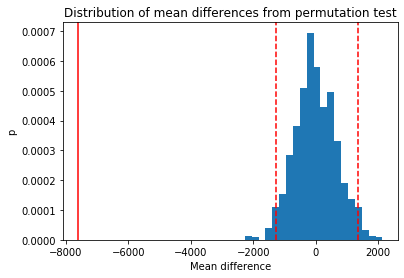

In [64]:
# calculate the CI
lower_CI, upper_CI = np.percentile(permutation_reps, [2.5, 97.5])

_ = plt.hist(permutation_reps, bins=20, density=True)
_ = plt.axvline(obs_mean_diff, color='r')
_ = plt.axvline(lower_CI, color='r', linestyle='--')
_ = plt.axvline(upper_CI, color='r', linestyle='--')
_ = plt.xlabel('Mean difference')
_ = plt.ylabel('p')
_ = plt.title('Distribution of mean differences from permutation test')
plt.show()

__Q:__ Compare your p-value above with that obtained using the _t_-test function in the previous assignment. Do you think you would want to try to perform enough bootstrap replicates to observe a random difference as large as that we did observe?

__A:__ The values are essentially the same. The t-test revealed there was 1 chance in $10^{22}$ of the observed difference being a false positive, and we found that zero of our $10^{3}$ samples were in the reject region. I wouldn't want to perform the $10^{22}$ test because it would take too long!!

__Q:__ Consider the two variants of the _t_-test we performed in the previous assignment. Which one would you use now?

__A:__ These are all useful tests. The t-test with exact p-value gives a better estimate of the significance of the effect, but the permutation test takes better account of the skew in the data. Thus, I would prefer the permutation test. 

Note: Neither of the two tests listed above take into account the differing spread between insured and non-insured patients (see cell below). As such, it would be better to use Welch's t-test or a bootstrap on recentered samples to provide a better estimate.

In [67]:
# Standard deviations of both samples
sd_ins = np.std(insured_charges)
sd_unins = np.std(uninsured_charges)
print('The SD of insured patients was ' + '{:.0f}'.format(sd_ins) +' and for noninsured was ' +
     '{:.0f}'.format(sd_unins))

The SD of insured patients was 6441 and for noninsured was 14037


__Q:__ If, instead of being asked whether the means of two groups were different, you were working with an ad-recommender team who wanted to release a new recommendation algorithm, and you were looking at click-through rate both for the current algorithm (call it A) and from trials of their new algorithm (call it B), would you perform a two-sided test as above? What would be your null and alternative hypotheses and what would be the real-world consequence of rejecting the null hypothesis?

__A:__ It depends on how effective the old algorithm is. If the old one is a complete failure, then we might like to know if the new one is better OR worse, necessitating a two-tail test. On the other hand, if the old algorithm is reasonably effective, a one-tailed right-hand test might be quite appropriate.

In the latter case,
Ho: The new algorithm has a click-through rate equivalent to the old algorithm
Ha: The new algorithm is better than the old algorithm

The real-world implication of rejecting the null is likely to be adoption of the new algorithm (all other things being equal).